<a href="https://colab.research.google.com/github/Zukumus/Lesons-test-task/blob/main/predict_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [150]:
# перводим в нужный тип, работаем с датами, переводим в тип ДАТА
aapl_df = pd.read_csv('/content/aapl.csv', parse_dates=['Date'])

In [151]:
print(aapl_df)

           Date       Open       High        Low      Close    Volume  OpenInt
0    1984-09-07    0.42388    0.42902    0.41874    0.42388  23220030        0
1    1984-09-10    0.42388    0.42516    0.41366    0.42134  18022532        0
2    1984-09-11    0.42516    0.43668    0.42516    0.42902  42498199        0
3    1984-09-12    0.42902    0.43157    0.41618    0.41618  37125801        0
4    1984-09-13    0.43927    0.44052    0.43927    0.43927  57822062        0
...         ...        ...        ...        ...        ...       ...      ...
8359 2017-11-06  171.75000  174.36000  171.10000  173.63000  34901241        0
8360 2017-11-07  173.29000  174.51000  173.29000  174.18000  24424877        0
8361 2017-11-08  174.03000  175.61000  173.71000  175.61000  24451166        0
8362 2017-11-09  174.48000  175.46000  172.52000  175.25000  29533086        0
8363 2017-11-10  175.11000  175.38000  174.27000  174.67000  25130494        0

[8364 rows x 7 columns]


In [152]:
aapl_df.head(2)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0


In [153]:
# выведим минимум и максимум
aapl_df['Date'].min(),aapl_df['Date'].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

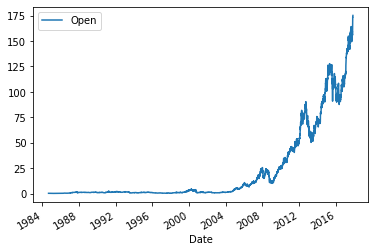

In [154]:
# вывести график зависимости  на старте и даты
aapl_df.plot(x='Date',y='Open')

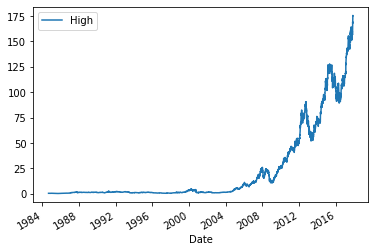

In [155]:
# вывести график зависимости цены максимум и даты
aapl_df.plot(x='Date',y='High')

In [156]:
# корреляци зависимости цен от показателей
aapl_df[['Open','Close','Low','High',	]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [157]:
# возьмём последние 6 лет 
aapl_df_6year=aapl_df[aapl_df['Date']>aapl_df['Date'].max()-timedelta(days=365*6)]

In [158]:
aapl_df_6year.shape

(1509, 7)

In [159]:
train_size = int(aapl_df_6year.shape[0]*0.8)
train_aapl_df = aapl_df_6year.iloc[:train_size]
test_aapl_df = aapl_df_6year.iloc[train_size:] 


In [160]:
train_aapl_df.shape, test_aapl_df.shape

((1207, 7), (302, 7))

In [161]:
train_aapl_df['Date'].min(),train_aapl_df['Date'].max(),test_aapl_df['Date'].min(),test_aapl_df['Date'].max(),

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

Bad code

In [227]:
scaler = StandardScaler()
scaler.fit(train_aapl_df[['Low']])

def make_dataset(
    df,
    # количество используемых элементов для предсказания следующего
    window_size,
    # размер партии элементов
    batch_size,
    use_scaler=True,
    # смешивание параметров
    shuffle=True,
    ):
  # берём признаки
  features = aapl_df[['Low']].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features,dtype=np.float32)
  # tensorflow
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data, 
      targets=aapl_df['Low'].iloc[window_size:], 
      sequence_length=window_size,
      # сдвиг элементов для создания нового элемента, т.е. последовательность шагов
      sequence_stride=1, 
      shuffle=shuffle,
      batch_size=batch_size, 
  )
  return ds

In [220]:
# масштабируем для нормализации из библиотеки Scikit-learn
scaler = StandardScaler()
scaler.fit(train_aapl_df[["Low"]])

def make_dataset(
  # количество используемых элементов для предсказания следующего
    df,
  # размер партии элементов
    window_size,
  # размер партии элементов
    batch_size,
    use_scaler=True,
  # смешивание параметров
    shuffle=True
    ):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
    # tensorflow
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
    # сдвиг элементов для создания нового элемента, т.е. последовательность шагов
      sequence_length=window_size,
    # сдвиг элементов для создания нового элемента, т.е. последовательность шагов
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size,
      )
  return ds

In [228]:
example_ds = make_dataset(df=train_aapl_df,window_size=3,batch_size=2,use_scaler=False,shuffle=False)

In [229]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [230]:
example_feature.shape


(2, 3, 1)

In [231]:
example_label.shape

(2,)

In [232]:
train_aapl_df['Low'].iloc[:6]
# size batch
# size window
# size feature

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [233]:
print(example_feature[0])
print(example_label[0])
print(example_feature[1])
print(example_label[1])
# первые три элемента признак, следующй лабел. это настраивается

[[0.41874]
 [0.41366]
 [0.42516]]
0.41618
[[0.41366]
 [0.42516]
 [0.41618]]
0.43927
